In [15]:
% pylab inline
import tensorflow as tf
import numpy as np
# import matplotlib.pyplot as plt
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm


from tensorflow.contrib.kfac.python.ops.utils import fwd_gradients
import seaborn as sns

slim = tf.contrib.slim
ds = tf.contrib.distributions


from functools import reduce
from operator import mul


import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import utils


Populating the interactive namespace from numpy and matplotlib


In [16]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [17]:
%%javascript
require(
        ["notebook/js/outputarea"],
        function (oa) {
            oa.OutputArea.auto_scroll_threshold = -1;
            console.log("Setting auto_scroll_threshold to -1");
        });

<IPython.core.display.Javascript object>


## Hyperparameters

In [18]:
params = dict(
    batch_size=10,
    unl_batch_size = 10,
    learning_rate=3e-4,
    beta1=0.5,
    epoch=1200,
    epsilon=1e-8,
    max_iter=20000,
    viz_every=2000,
    z_dim=256,
    x_dim=2,
    optimizer='rmsprop', # rmsprop sgd sga
    seed = 122524,
    nabla = 0,
    l2_w = 0. 
)
rng = np.random.RandomState(params['seed'])  # seed labels

## Data Creation

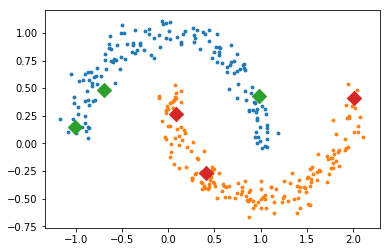

In [19]:
labeled =3
x,y=make_moons(n_samples=1000, shuffle=True, noise=0.08, random_state=rng.randint(2**10))
trainx, testx, trainy, testy = train_test_split(x, y, test_size=0.33, random_state=rng.randint(2**10))
trainx_unl = trainx.copy()

inds = rng.permutation(trainx.shape[0])
trainx = trainx[inds]
trainy = trainy[inds]
txs = []
tys = []
for j in range(10):
    txs.append(trainx[trainy == j][:labeled])
    tys.append(trainy[trainy == j][:labeled])
txs = np.concatenate(txs, axis=0)
tys = np.concatenate(tys, axis=0)
trainx = txs
trainy = tys

nr_batch_train = trainx.shape[0] // params['batch_size']
nr_batch_test = testx.shape[0] // params['batch_size']

utils.scatter_2_class(testx,testy,s=8)
# utils.scatter_2_class(trainx_unl,np.ones(trainx_unl.shape[0]),s=1,c='k')
utils.scatter_2_class(trainx,trainy,marker = 'D',s=100)
plt.show()


In [20]:
nr_batch_test

33

In [21]:
def discriminator(x, n_hidden=384, n_layer=6, reuse=False):
    with tf.variable_scope("classifier", reuse=reuse):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=None,weights_regularizer=slim.l2_regularizer(0.1))
    return log_d

## Build model

In [22]:
tf.reset_default_graph()

In [23]:
unl_dataset = tf.data.Dataset.from_tensor_slices(trainx_unl)
unl_dataset = unl_dataset.shuffle(10000).repeat().batch(params['unl_batch_size'])

train_dataset = tf.data.Dataset.from_tensor_slices((trainx, trainy))
train_dataset = train_dataset.shuffle(10000).repeat().batch(params['batch_size'])

test_dataset = tf.data.Dataset.from_tensor_slices((testx, testy))
test_dataset = test_dataset.repeat().batch(params['batch_size'])

iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
next_element, next_label = iterator.get_next()
training_init_op = iterator.make_initializer(train_dataset)
validation_init_op = iterator.make_initializer(test_dataset)

iterator_unl = unl_dataset.make_one_shot_iterator()
next_unl = iterator_unl.get_next()

In [24]:
with slim.arg_scope([slim.fully_connected], weights_initializer=tf.orthogonal_initializer(gain=1.2)):
    logits = tf.squeeze(discriminator(next_element))
    logits_unl = tf.squeeze(discriminator(next_unl,reuse = True))

# delta = tf.random_normal([params['unl_batch_size'],2], mean=0, stddev=0.1,dtype=tf.float64)
# x_delta = next_unl+delta 
# logits_unl_delta = tf.squeeze(discriminator(x_delta,reuse = True))

# add nabla penalty
jacob_norm = tf.reduce_sum(tf.square(tf.gradients(logits_unl,next_unl)),axis=[0,2])
j_loss = tf.reduce_mean(jacob_norm)
_l2 = tf.losses.get_regularization_losses()

# jacob_norm = tf.square(tf.nn.softmax(logits_unl) - tf.nn.softmax(logits_unl_delta))
# j_loss = tf.reduce_mean(jacob_norm)

xloss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=tf.cast(next_label,tf.float64))) 

loss = xloss + params['nabla'] * j_loss + params['l2_w']* _l2[0]

optimizer = tf.train.RMSPropOptimizer(params['learning_rate'])
train_op = optimizer.minimize(loss)

accuracy = utils.accuracy(logits,next_label)
prediction = utils.prediction(logits)

In [25]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [26]:
xls=[]; jls =[]
reg = []
sess.run(training_init_op)
for i in tqdm(range(params['epoch'])):
    xl,jl, _, acc,l2 = sess.run([xloss, j_loss, train_op, accuracy,_l2])
    xls.append(xl); jls.append(jl); reg.append(l2)
    if i % 100 == 0:
        print("Epoch: {}, loss: {:.5f}, training accuracy: {:.2f}%".format(i, xl, acc * 100))

    if i % 200 == 0:
        sess.run(validation_init_op)
        avg_acc = 0; pred = []; valid_iters = nr_batch_test; nabla_datapoint = []
        deltax = []
        for i in range(valid_iters):
            acc,p,dl = sess.run([accuracy,prediction,jacob_norm])
            avg_acc += acc
            pred.append(p); nabla_datapoint.append(dl)
        print("Average validation set accuracy over {} iterations is {:.2f}%".format(valid_iters,(avg_acc / valid_iters) * 100))
        pred = np.concatenate(pred); _nabla = np.concatenate(nabla_datapoint)
        sess.run(training_init_op)


Epoch: 0, loss: 0.69330, training accuracy: 50.00%
Average validation set accuracy over 33 iterations is 53.64%
Epoch: 100, loss: 0.64934, training accuracy: 90.00%
Epoch: 200, loss: 0.00425, training accuracy: 100.00%
Average validation set accuracy over 33 iterations is 82.42%
Epoch: 300, loss: 0.00001, training accuracy: 100.00%
Epoch: 400, loss: 0.00000, training accuracy: 100.00%
Average validation set accuracy over 33 iterations is 79.70%
Epoch: 500, loss: 0.00000, training accuracy: 100.00%
Epoch: 600, loss: 0.00000, training accuracy: 100.00%
Average validation set accuracy over 33 iterations is 80.00%
Epoch: 700, loss: 0.00000, training accuracy: 100.00%
Epoch: 800, loss: 0.00000, training accuracy: 100.00%
Average validation set accuracy over 33 iterations is 80.00%
Epoch: 900, loss: 0.00000, training accuracy: 100.00%
Epoch: 1000, loss: 0.00000, training accuracy: 100.00%
Average validation set accuracy over 33 iterations is 80.00%
Epoch: 1100, loss: 0.00000, training accura

/home/bruno/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7f5ccc034400> has a label of '_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/home/bruno/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7f5ccc0346d8> has a label of '_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


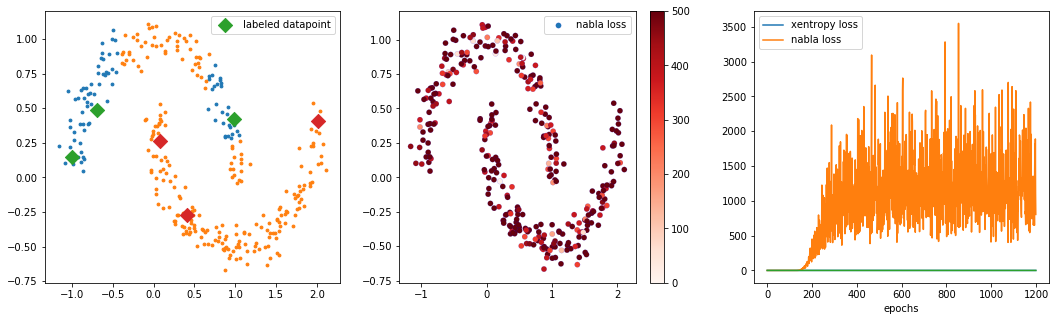

In [13]:
plt.figure(1,figsize=(18,5))
plt.subplot(131)
utils.scatter_2_class(testx,pred,s=8)
utils.scatter_2_class(trainx,trainy, marker='D',s=100)
plt.legend(['_','_','labeled datapoint'])
plt.subplot(132)
plt.scatter(testx[:,0],testx[:,1], s=30, c=_nabla, alpha=1.,cmap='Reds',norm=None,vmin=0, vmax=500,linewidths=0.1,edgecolors='b')
plt.colorbar()
# plt.title('nabla loss')
plt.legend(['nabla loss'])
plt.subplot(133)                      
plt.plot(xls)
plt.plot(jls)
plt.plot(reg)
# plt.ylim([10^-2,10^(-3)])
xlabel('epochs')
plt.legend(['xentropy loss', 'nabla loss'])

plt.show()

In [14]:
# utils.scatter_2_class(testx,pred,s=8)
utils.scatter_2_class(deltax,pred,s=8)
plt.show()

TypeError: list indices must be integers or slices, not tuple